
     Import Necessary Libraries



In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


     Load the Data


In [3]:
train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = '/kaggle/input/new-plant-diseases-dataset/test/test'


    Collecting file paths and their corresponding labels from training directory



In [4]:
filenames_train = []
label_train = []
folds = os.listdir(train_dir)
for fold in folds: 
    FoldPath = os.path.join(train_dir, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filenames_train.append(filepath)
        label_train.append(fold)

100%|██████████| 1859/1859 [00:00<00:00, 672289.29it/s]


     Collecting file paths and their corresponding labels from valid directory



In [5]:
filenames_valid = []
label_valid = []
folds = os.listdir(valid_dir)
for fold in folds:
    FoldPath = os.path.join(valid_dir, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filenames_valid.append(filepath)
        label_valid.append(fold)

100%|██████████| 465/465 [00:00<00:00, 585515.27it/s]


     Creating DataFrames for training and validation data



In [6]:
df_train = pd.DataFrame({
    'filename': filenames_train,
    'label': label_train
})
df_valid = pd.DataFrame({
    'filename': filenames_valid,
    'label': label_valid
})

 
     Explore data


In [7]:
print(df_train.shape)
print(df_valid.shape)

(70295, 2)
(17572, 2)


In [8]:
df_train.head(5)

filename                 label
0  /kaggle/input/new-plant-diseases-dataset/New P...  Tomato___Late_blight
1  /kaggle/input/new-plant-diseases-dataset/New P...  Tomato___Late_blight
2  /kaggle/input/new-plant-diseases-dataset/New P...  Tomato___Late_blight
3  /kaggle/input/new-plant-diseases-dataset/New P...  Tomato___Late_blight
4  /kaggle/input/new-plant-diseases-dataset/New P...  Tomato___Late_blight

In [9]:
df_train.sample(5)


filename  \
48938  /kaggle/input/new-plant-diseases-dataset/New P...   
38356  /kaggle/input/new-plant-diseases-dataset/New P...   
14669  /kaggle/input/new-plant-diseases-dataset/New P...   
40709  /kaggle/input/new-plant-diseases-dataset/New P...   
68063  /kaggle/input/new-plant-diseases-dataset/New P...   

                                     label  
48938                 Strawberry___healthy  
38356             Apple___Cedar_apple_rust  
14669  Corn_(maize)___Northern_Leaf_Blight  
40709               Pepper,_bell___healthy  
68063        Pepper,_bell___Bacterial_spot

In [10]:
color = ['#CAE0BC','#780C28','#EAFAEA','#6E8E59']

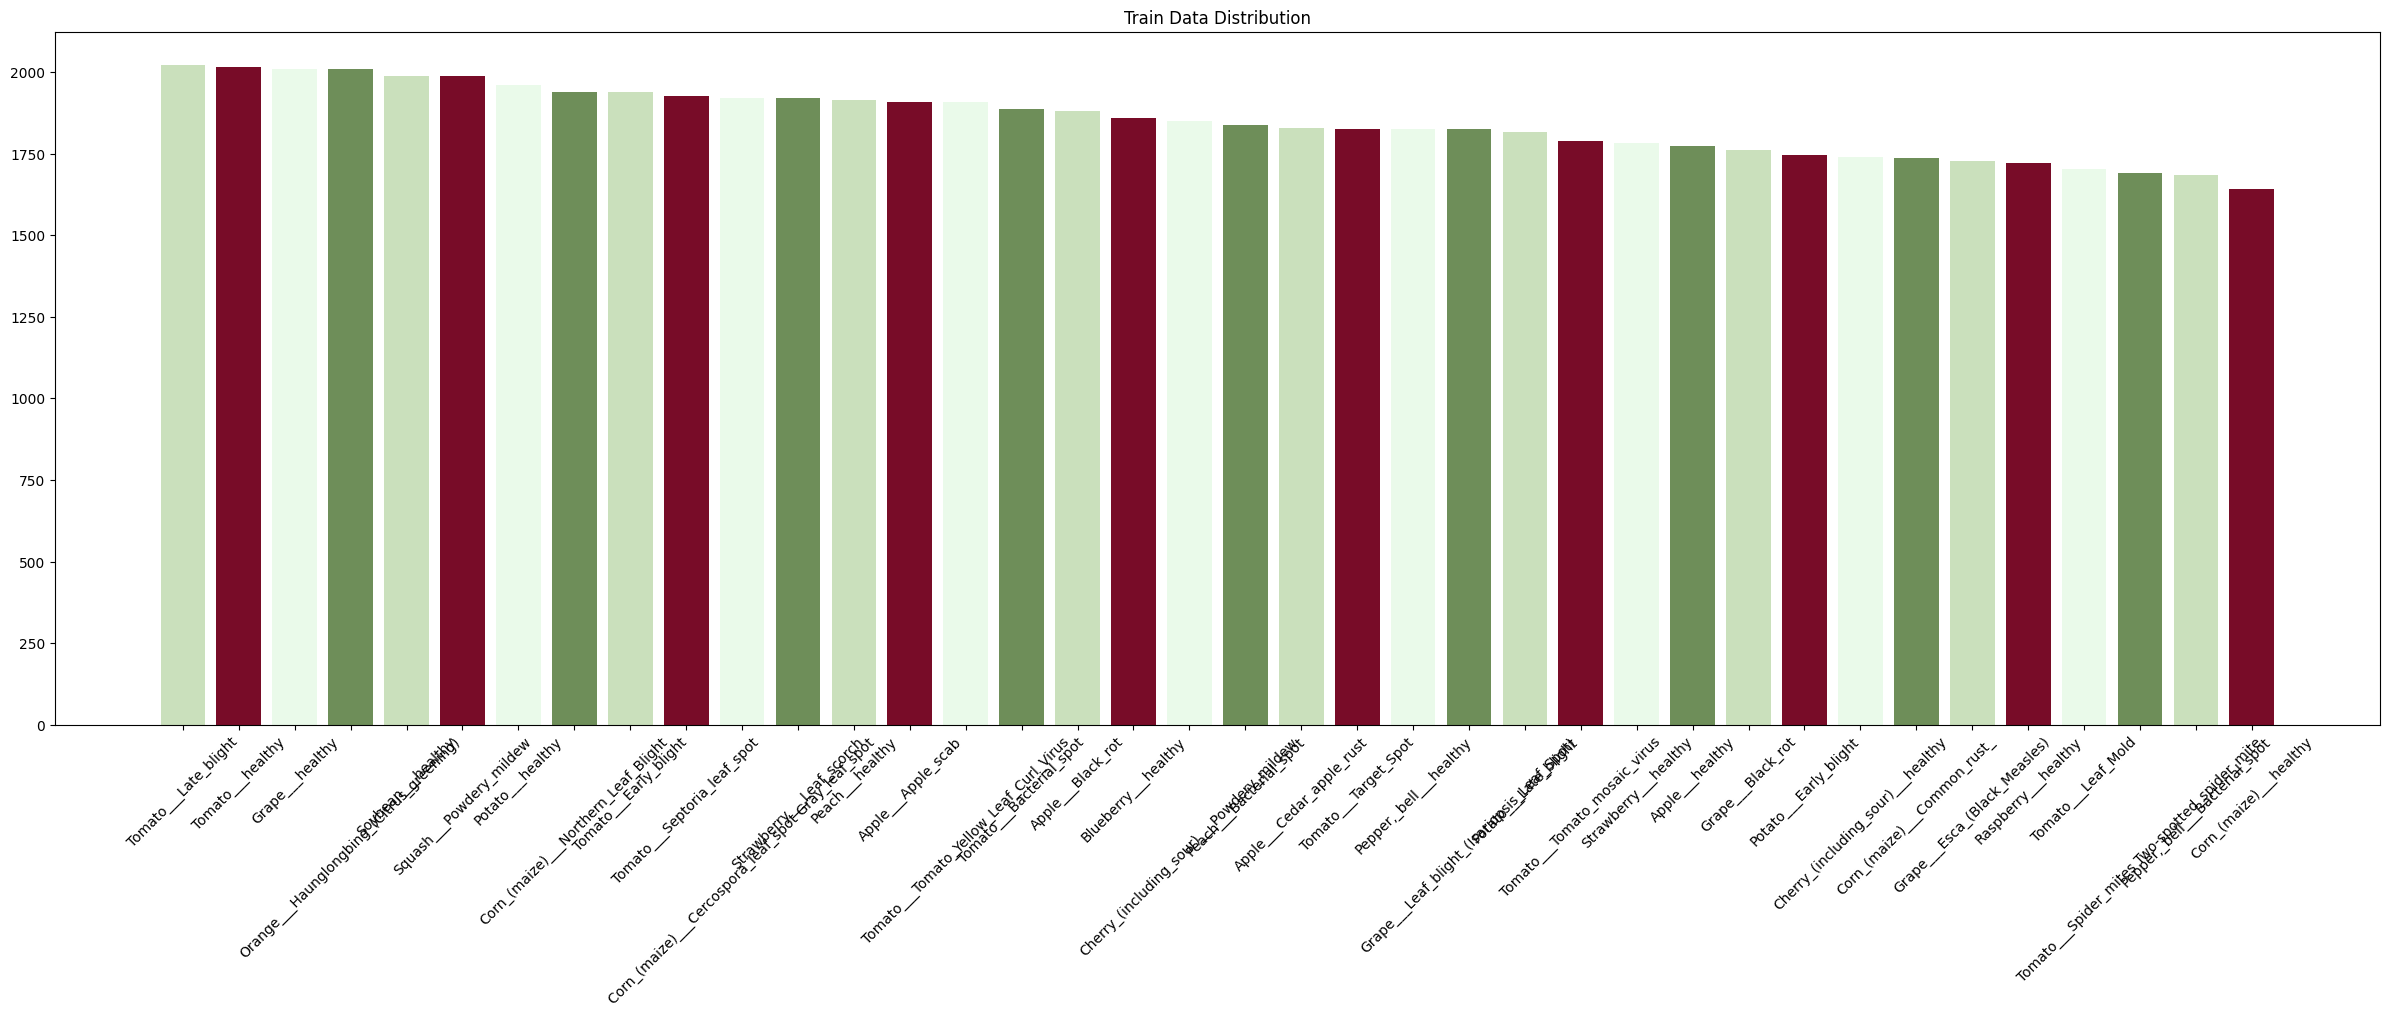

In [11]:
plt.figure(figsize=(30,9))
plt.bar(df_train['label'].unique(), df_train['label'].value_counts(), color=color)
plt.title('Train Data Distribution')
plt.xticks(rotation=45)
plt.show()

In [12]:
print(np.unique(label_train))

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

      Creating ImageDataGenerator for data augmentation and normalization


In [13]:
data_gen  = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# only normalization
test_gen = ImageDataGenerator(rescale=1./255)


imge_size = (224,224)
batch_size = 32



     Creating data generators from DataFrames for training and validation


In [14]:
train_gen = data_gen.flow_from_dataframe(
    df_train,
    x_col='filename',
    shuffle=True,
    y_col='label',
    target_size=(imge_size[0],imge_size[1]),
    class_mode='categorical',
    batch_size=batch_size)

valid_gen = data_gen.flow_from_dataframe(
    df_valid,
    shuffle=True,
    x_col='filename',
    y_col='label',
    target_size=(imge_size[0],imge_size[1]),
    class_mode='categorical')



Found 70295 validated image filenames belonging to 38 classes.
Found 17572 validated image filenames belonging to 38 classes.



     Retrieving class indices mapping from the training generator


In [15]:
class_dict = train_gen.class_indices
print(class_dict)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato


     Creating a Convolutional Neural Network (CNN) model


In [16]:
Model = Sequential([
    Conv2D(64, kernel_size= (3,3),padding='same', activation='relu', input_shape=(imge_size[0],imge_size[1],3)),
    Conv2D(64, kernel_size= (3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    
    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(256, kernel_size= (3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(38, activation='softmax') ])

 
     Displaying the summary of the CNN model architecture


In [17]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 10,905,382 (41.60 MB)

 Trainable params: 10,902,182 (41.59 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [18]:
Model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


     Training the CNN model with early stopping


In [19]:
history = Model.fit(
    train_gen,
    epochs=40,
    validation_data=valid_gen,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
    
    )

Epoch 1/40
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1315s 588ms/step - accuracy: 0.3183 - loss: 2.5638 - val_accuracy: 0.5275 - val_loss: 1.9147
Epoch 2/40
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 971s 441ms/step - accuracy: 0.7651 - loss: 0.8426 - val_accuracy: 0.5996 - val_loss: 1.8319
Epoch 3/40
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 963s 437ms/step - accuracy: 0.8880 - loss: 0.3965 - val_accuracy: 0.8688 - val_loss: 0.4529
Epoch 4/40
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 966s 439ms/step - accuracy: 0.9282 - loss: 0.2486 - val_accuracy: 0.9307 - val_loss: 0.2333
Epoch 5/40
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 980s 445ms/step - accuracy: 0.9498 - loss: 0.1812 - val_accuracy: 0.9135 - val_loss: 0.3071
Epoch 6/40
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 967s 439ms/step - accuracy: 0.9582 - loss: 0.1431 - val_accuracy: 0.9314 - val_loss: 0.2460
Epoch 7/40
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 961s 436ms/step - accuracy: 0.9670 - loss: 0.1144 - val_accuracy: 0.9462 - val_loss: 0.1771
Epoch 8/40
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 954s 433ms/step - a

In [21]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(imge_size[0], imge_size[1]),
    shuffle=False,
    labels=None  
)

Found 33 files.



      Evaluating the CNN model on training and validation data


In [22]:
print(Model.evaluate(train_gen))
print(Model.evaluate(valid_gen))


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 780s 355ms/step - accuracy: 0.9780 - loss: 0.0750
[0.07346775382757187, 0.9780923128128052]
550/550 ━━━━━━━━━━━━━━━━━━━━ 193s 351ms/step - accuracy: 0.9736 - loss: 0.0951
[0.09847278892993927, 0.9723992943763733]


ValueError: None values not supported.

In [59]:
Model.save('Modelplanit_ACC97.23.h5')

In [29]:
preds = Model.predict(valid_gen)
y_pred = np.argmax(preds, axis=1)

550/550 ━━━━━━━━━━━━━━━━━━━━ 193s 349ms/step


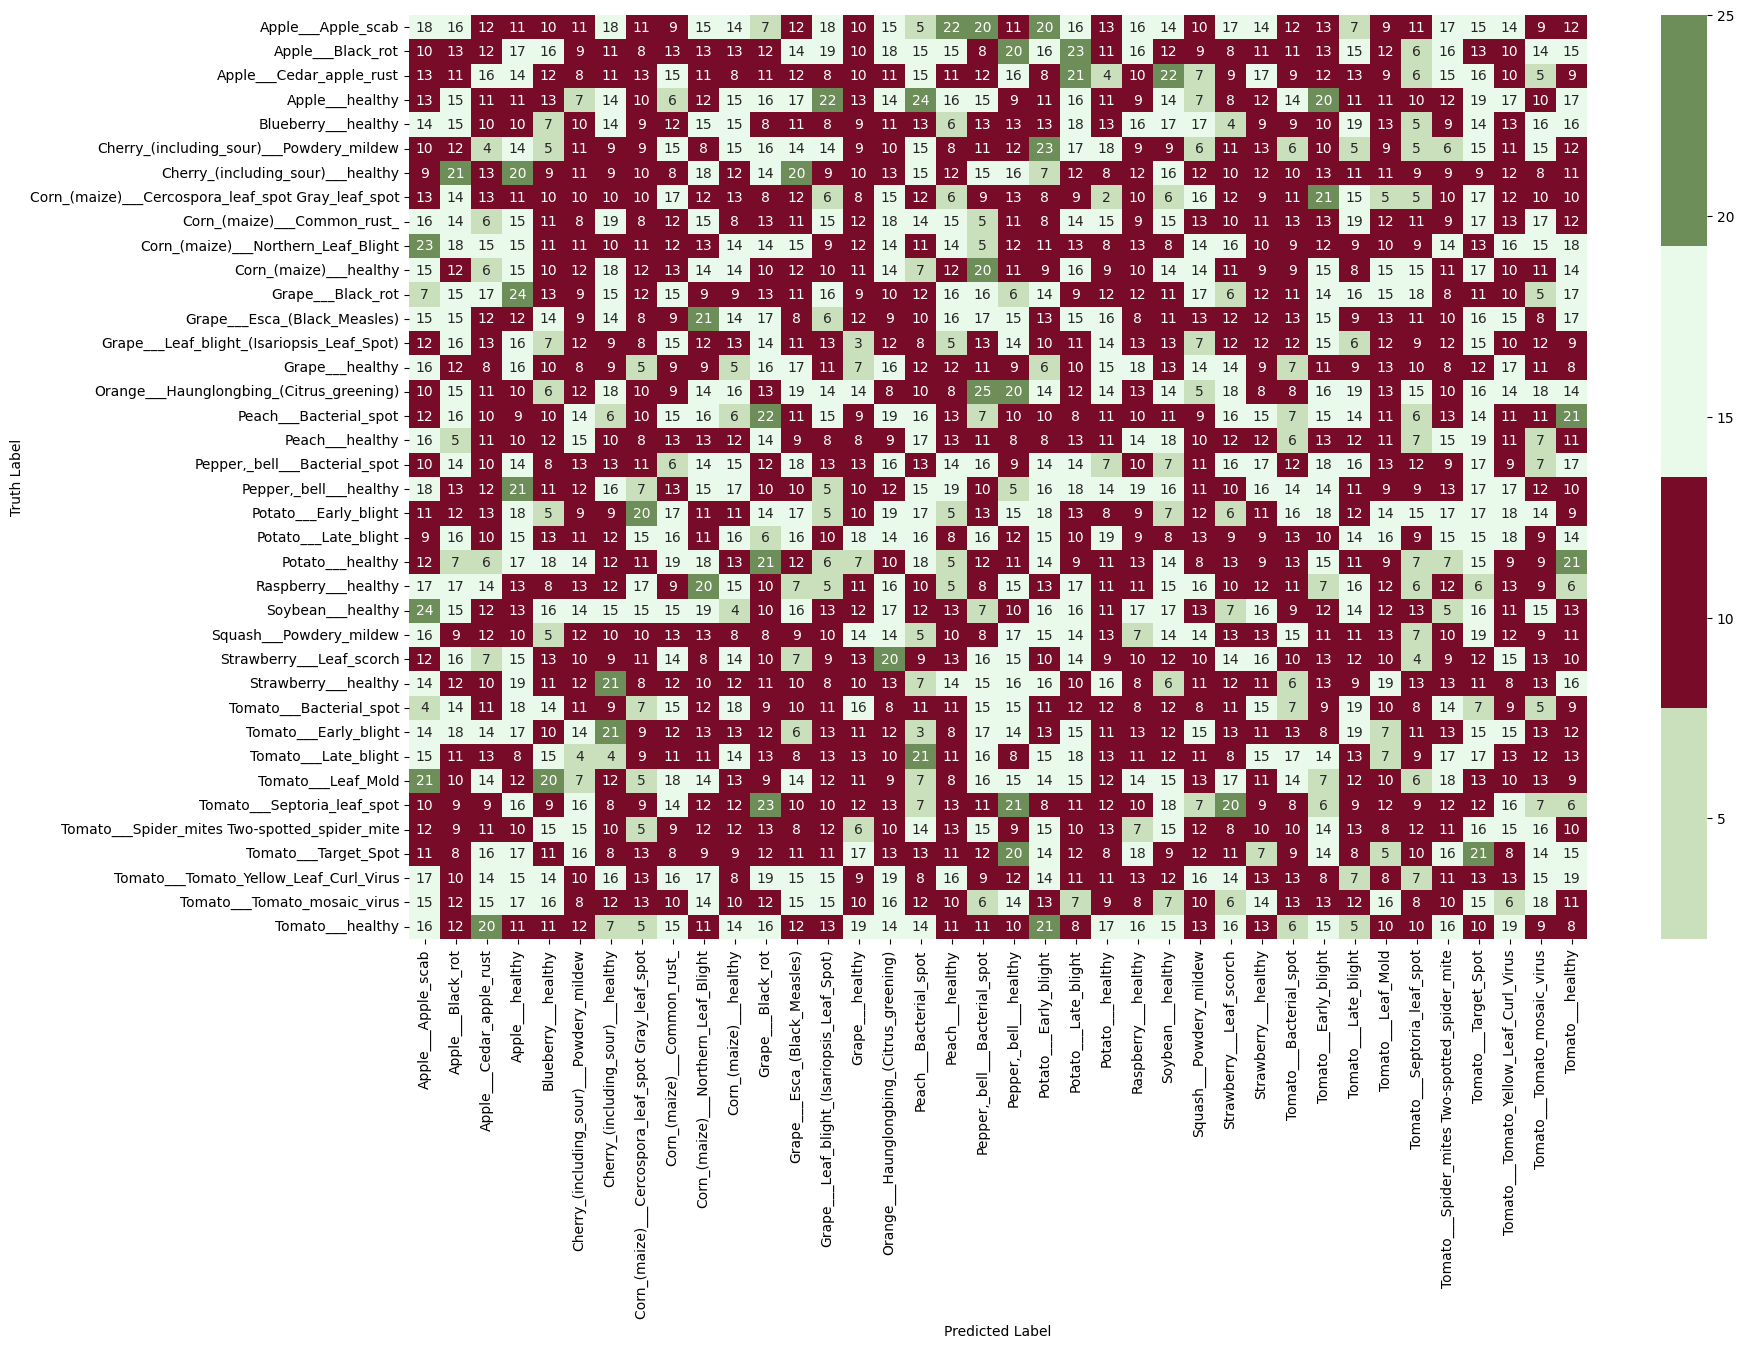

In [32]:
cm = confusion_matrix(valid_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(19,12))
sns.heatmap(cm, annot=True, fmt='d', cmap=color, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

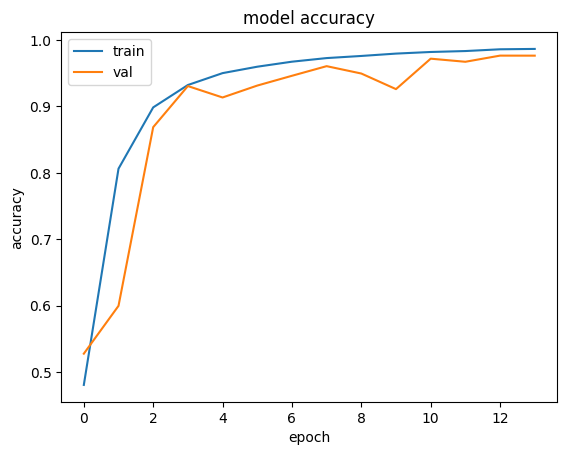

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

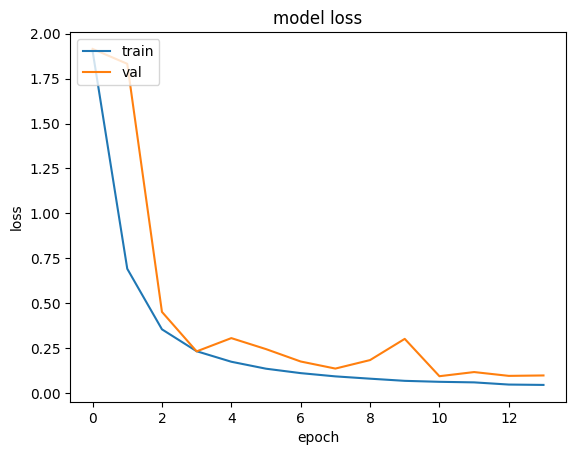

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [40]:
def predict(img_path):

    
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 19))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = Model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


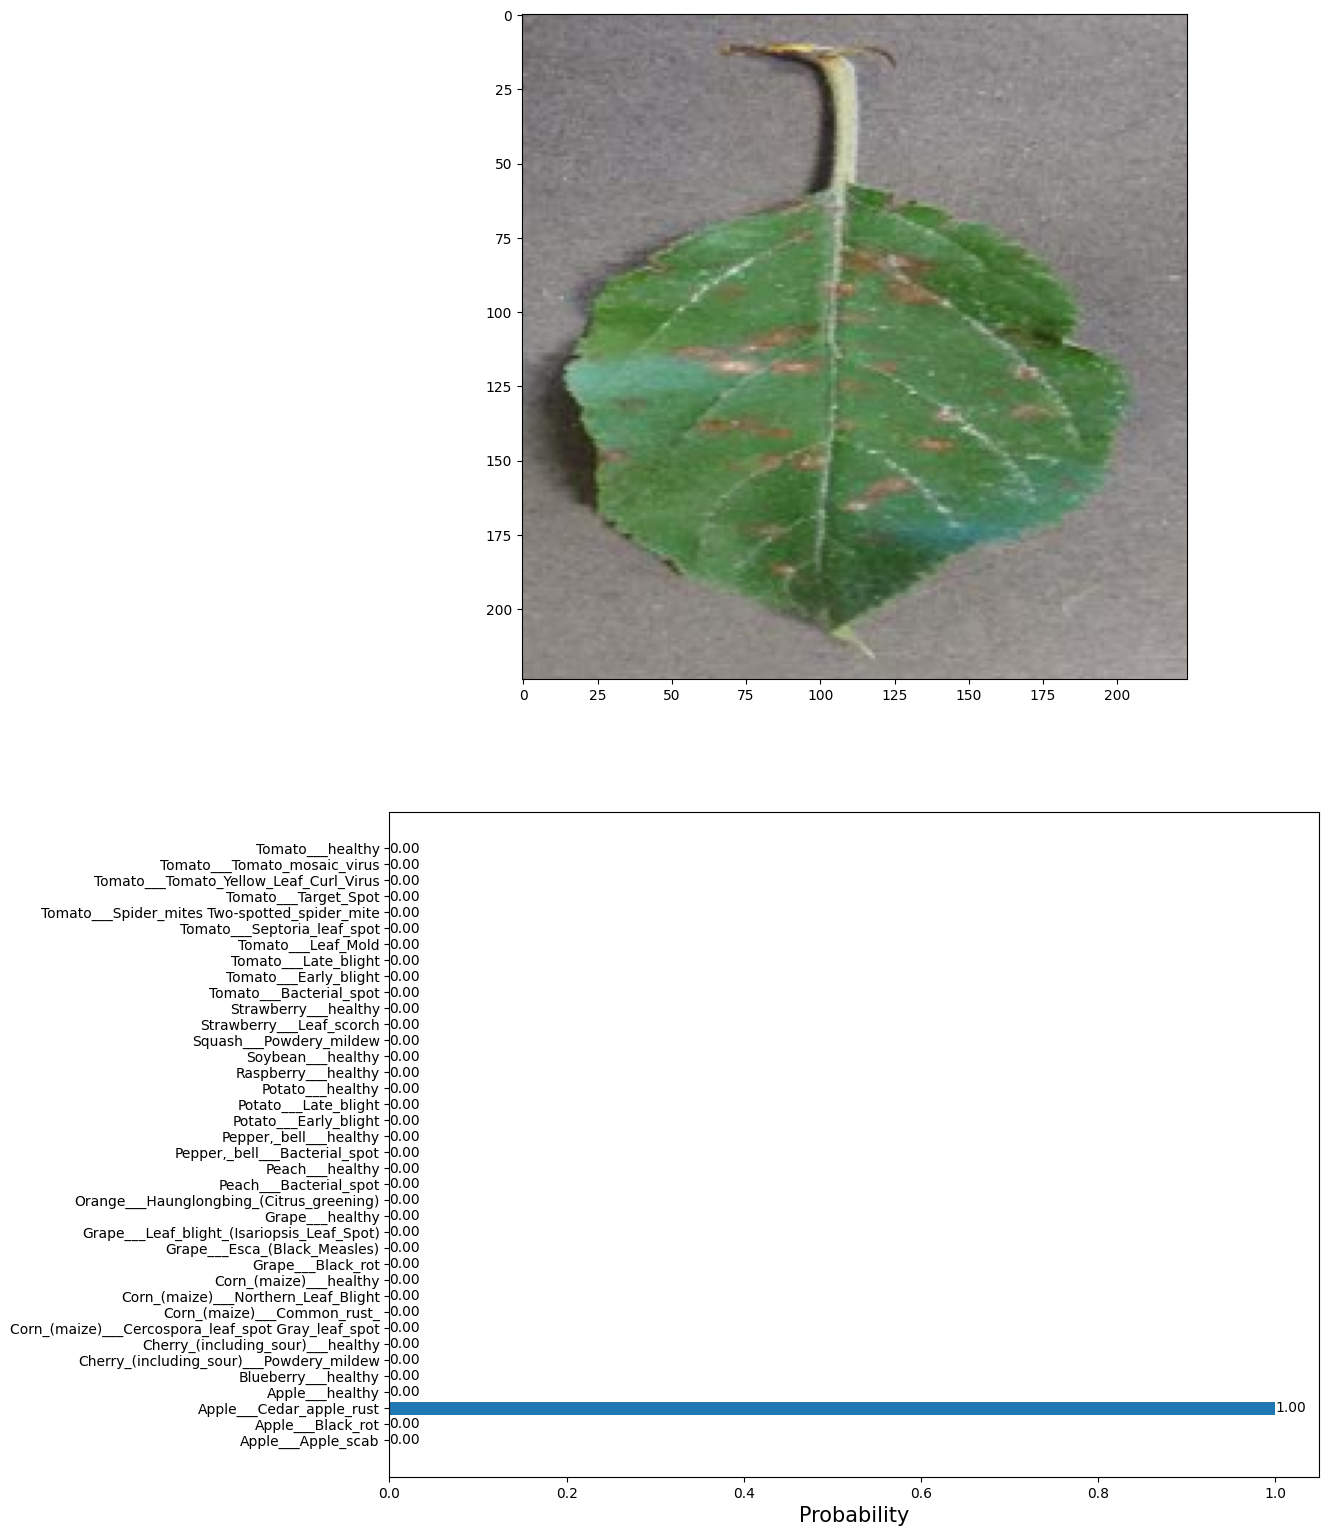

In [41]:
predict('/kaggle/input/new-plant-diseases-dataset/test/test/AppleCedarRust2.JPG')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


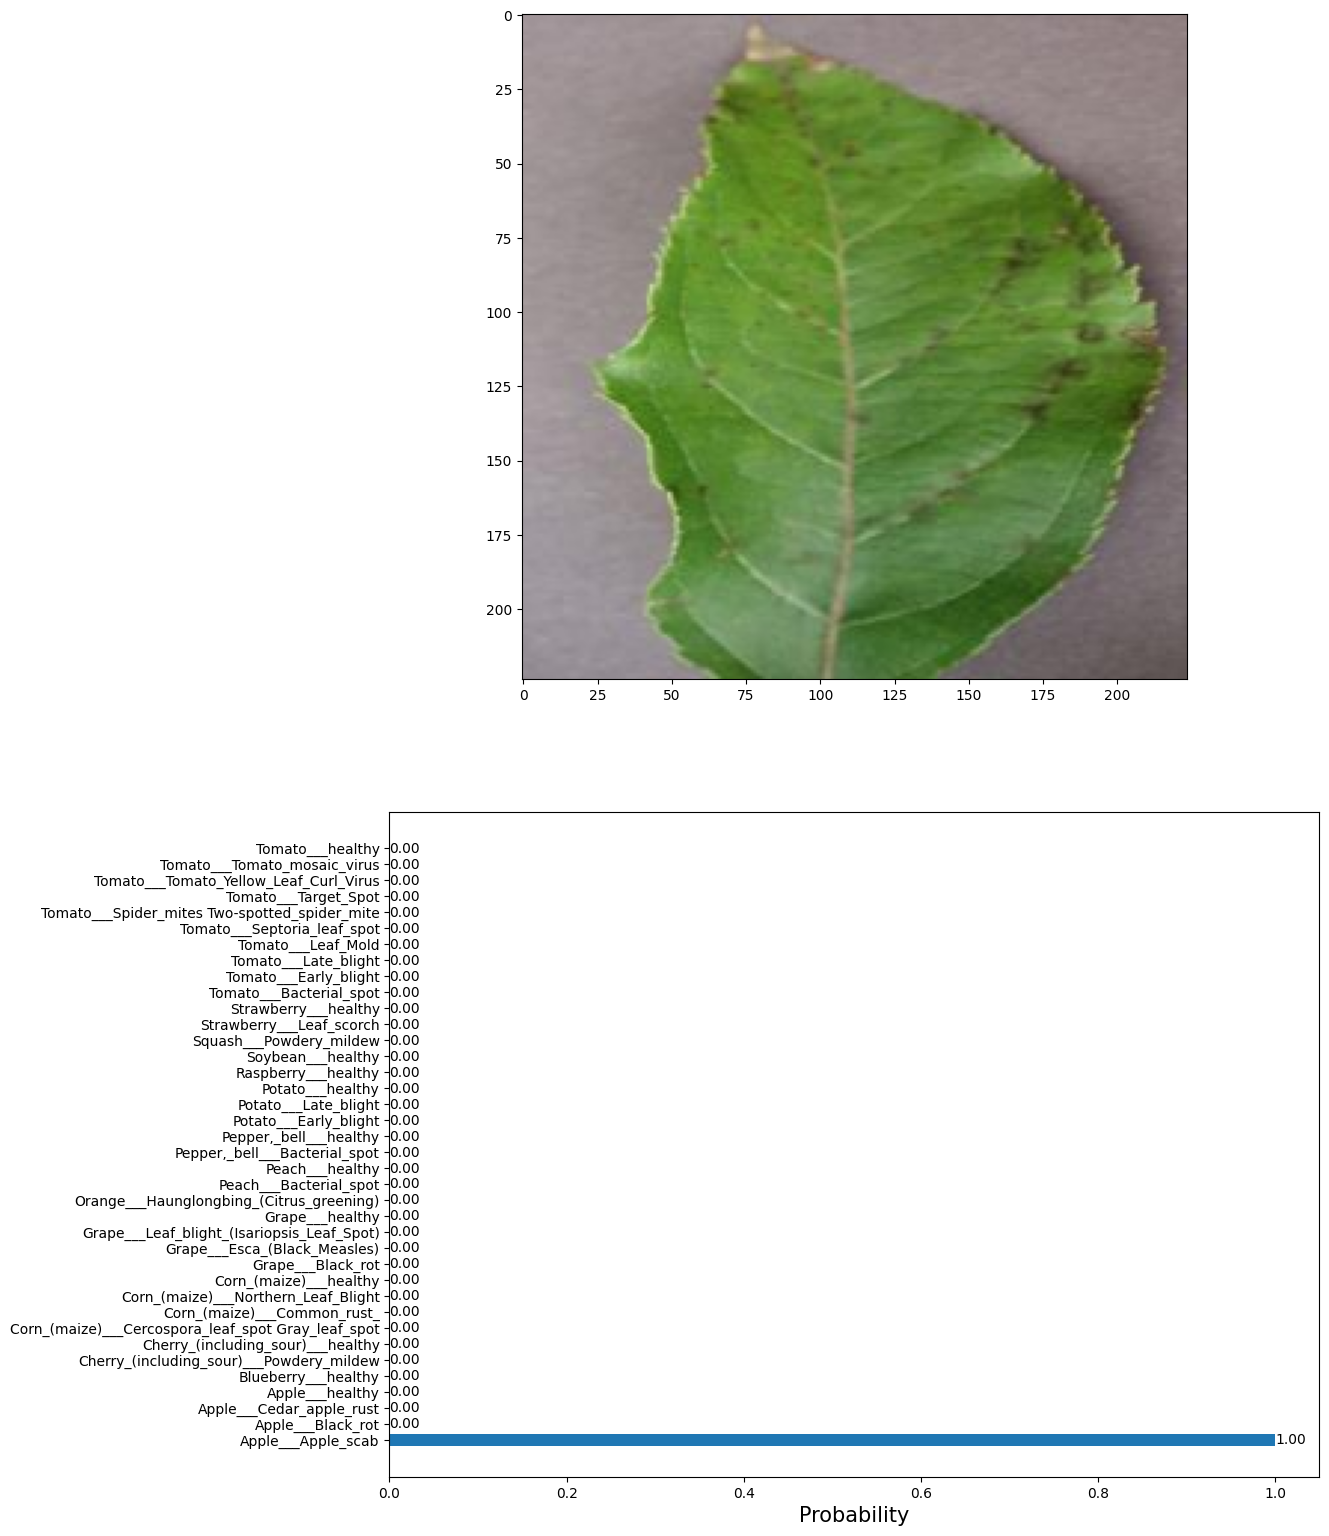

In [42]:
predict('/kaggle/input/new-plant-diseases-dataset/test/test/AppleScab1.JPG')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


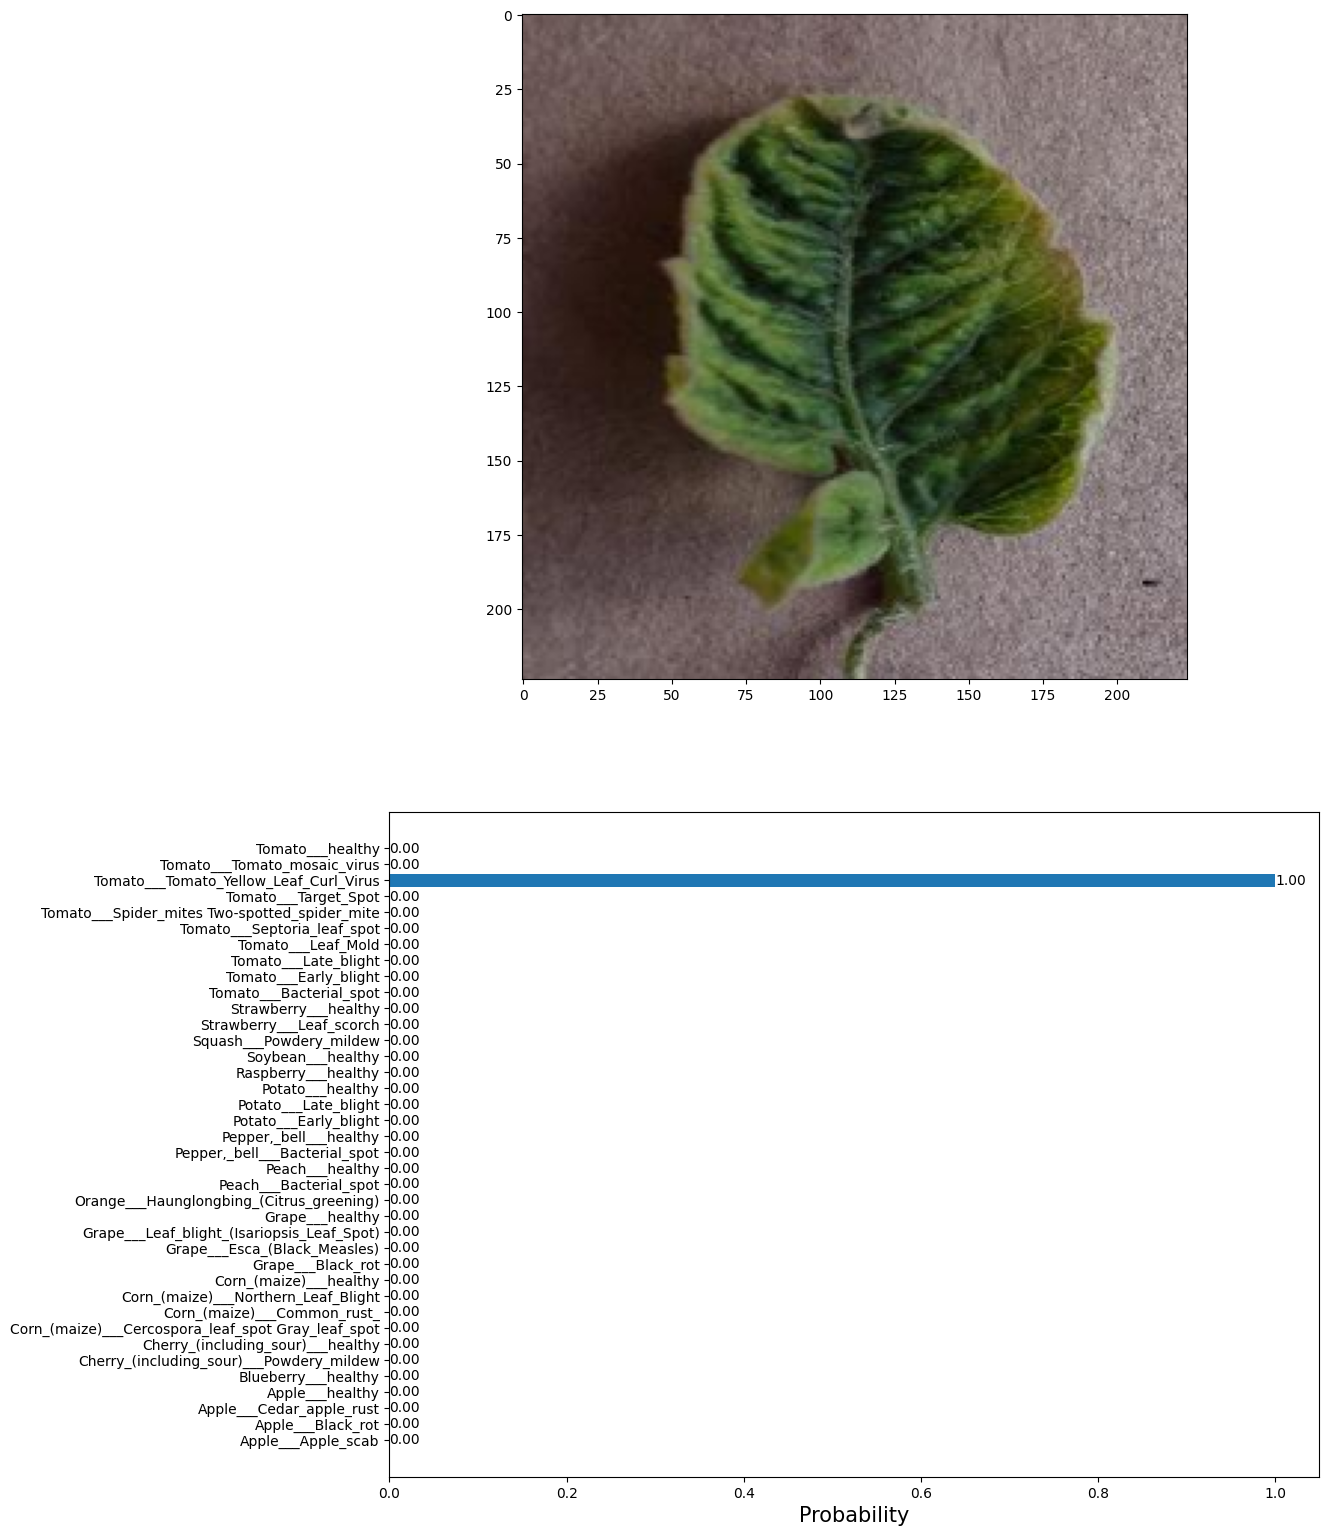

In [43]:
predict('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus2.JPG')


In [45]:
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(imge_size[0],imge_size[1],3),
    pooling='max',
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [48]:
ModelPretrained = Sequential([
    base_model,
    
    Dense(256 , activation='relu'),
    Dropout(0.3),
    Dense(38, activation='softmax')
    
])
ModelPretrained.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
history_Final = ModelPretrained.fit(
    train_gen, 
    epochs=5, 
    validation_data=valid_gen, 
    verbose=1, 
    
)

Epoch 1/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1172s 487ms/step - accuracy: 0.7750 - loss: 0.9704 - val_accuracy: 0.9884 - val_loss: 0.0336
Epoch 2/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 992s 450ms/step - accuracy: 0.9782 - loss: 0.0736 - val_accuracy: 0.9921 - val_loss: 0.0287
Epoch 3/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 996s 452ms/step - accuracy: 0.9888 - loss: 0.0415 - val_accuracy: 0.9941 - val_loss: 0.0192
Epoch 4/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1002s 455ms/step - accuracy: 0.9928 - loss: 0.0259 - val_accuracy: 0.9963 - val_loss: 0.0120
Epoch 5/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1018s 462ms/step - accuracy: 0.9938 - loss: 0.0207 - val_accuracy: 0.9959 - val_loss: 0.0148


In [50]:
print(ModelPretrained.evaluate(train_gen))
print(ModelPretrained.evaluate(valid_gen))

2197/2197 ━━━━━━━━━━━━━━━━━━━━ 817s 372ms/step - accuracy: 0.9979 - loss: 0.0069
[0.007135253865271807, 0.9977949857711792]
550/550 ━━━━━━━━━━━━━━━━━━━━ 198s 360ms/step - accuracy: 0.9952 - loss: 0.0163
[0.017256472259759903, 0.9953334927558899]


In [58]:
ModelPretrained.save('Plant_Village_Detection_Model_ACC99.53%.h5')

In [53]:
preds = ModelPretrained.predict(valid_gen)
y_pred_ModelPretrained = np.argmax(preds, axis=1)

550/550 ━━━━━━━━━━━━━━━━━━━━ 204s 372ms/step


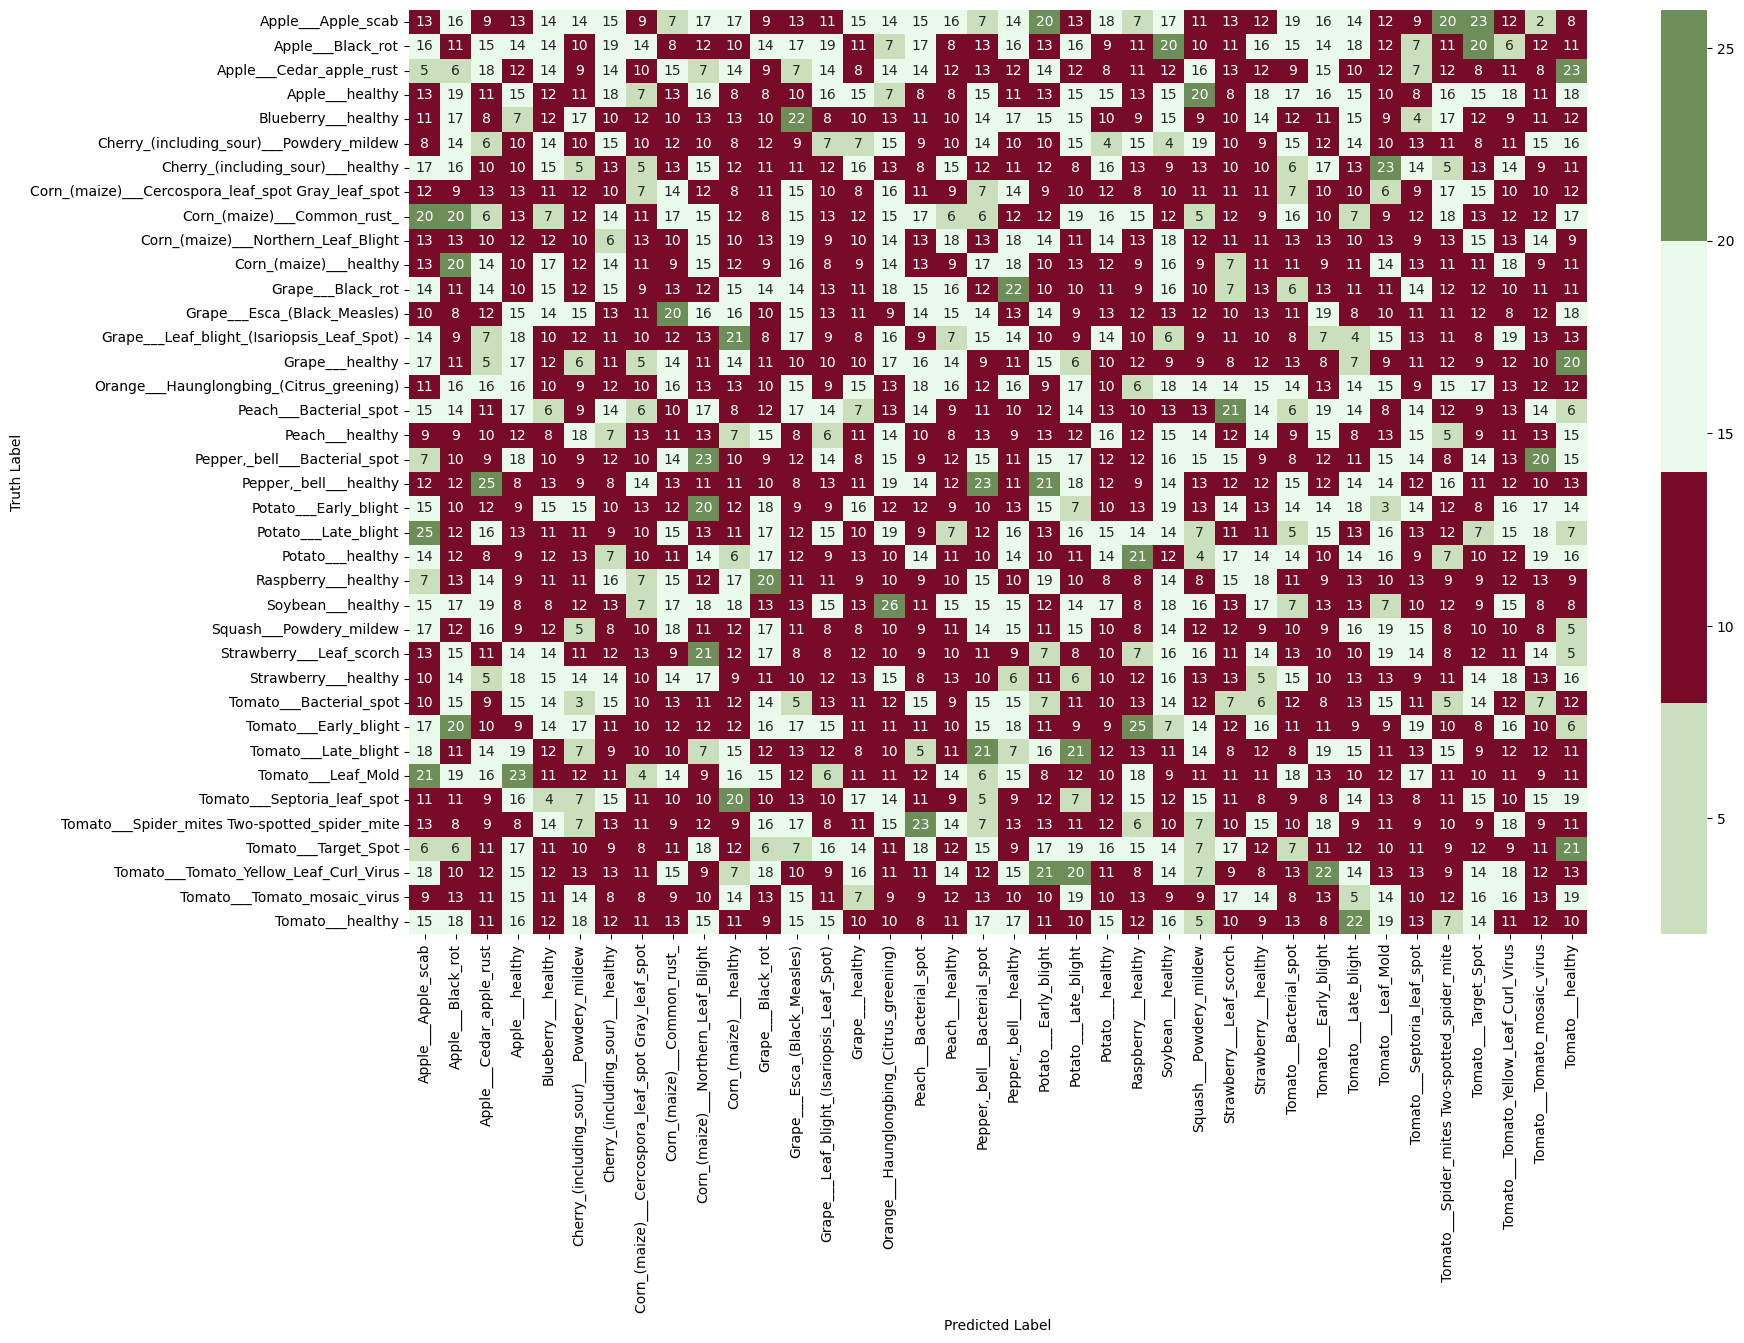

In [54]:
cm = confusion_matrix(valid_gen.classes, y_pred_ModelPretrained)
labels = list(class_dict.keys())
plt.figure(figsize=(19,12))
sns.heatmap(cm, annot=True, fmt='d', cmap=color, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [55]:
def predict(img_path):

    
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 19))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = ModelPretrained.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


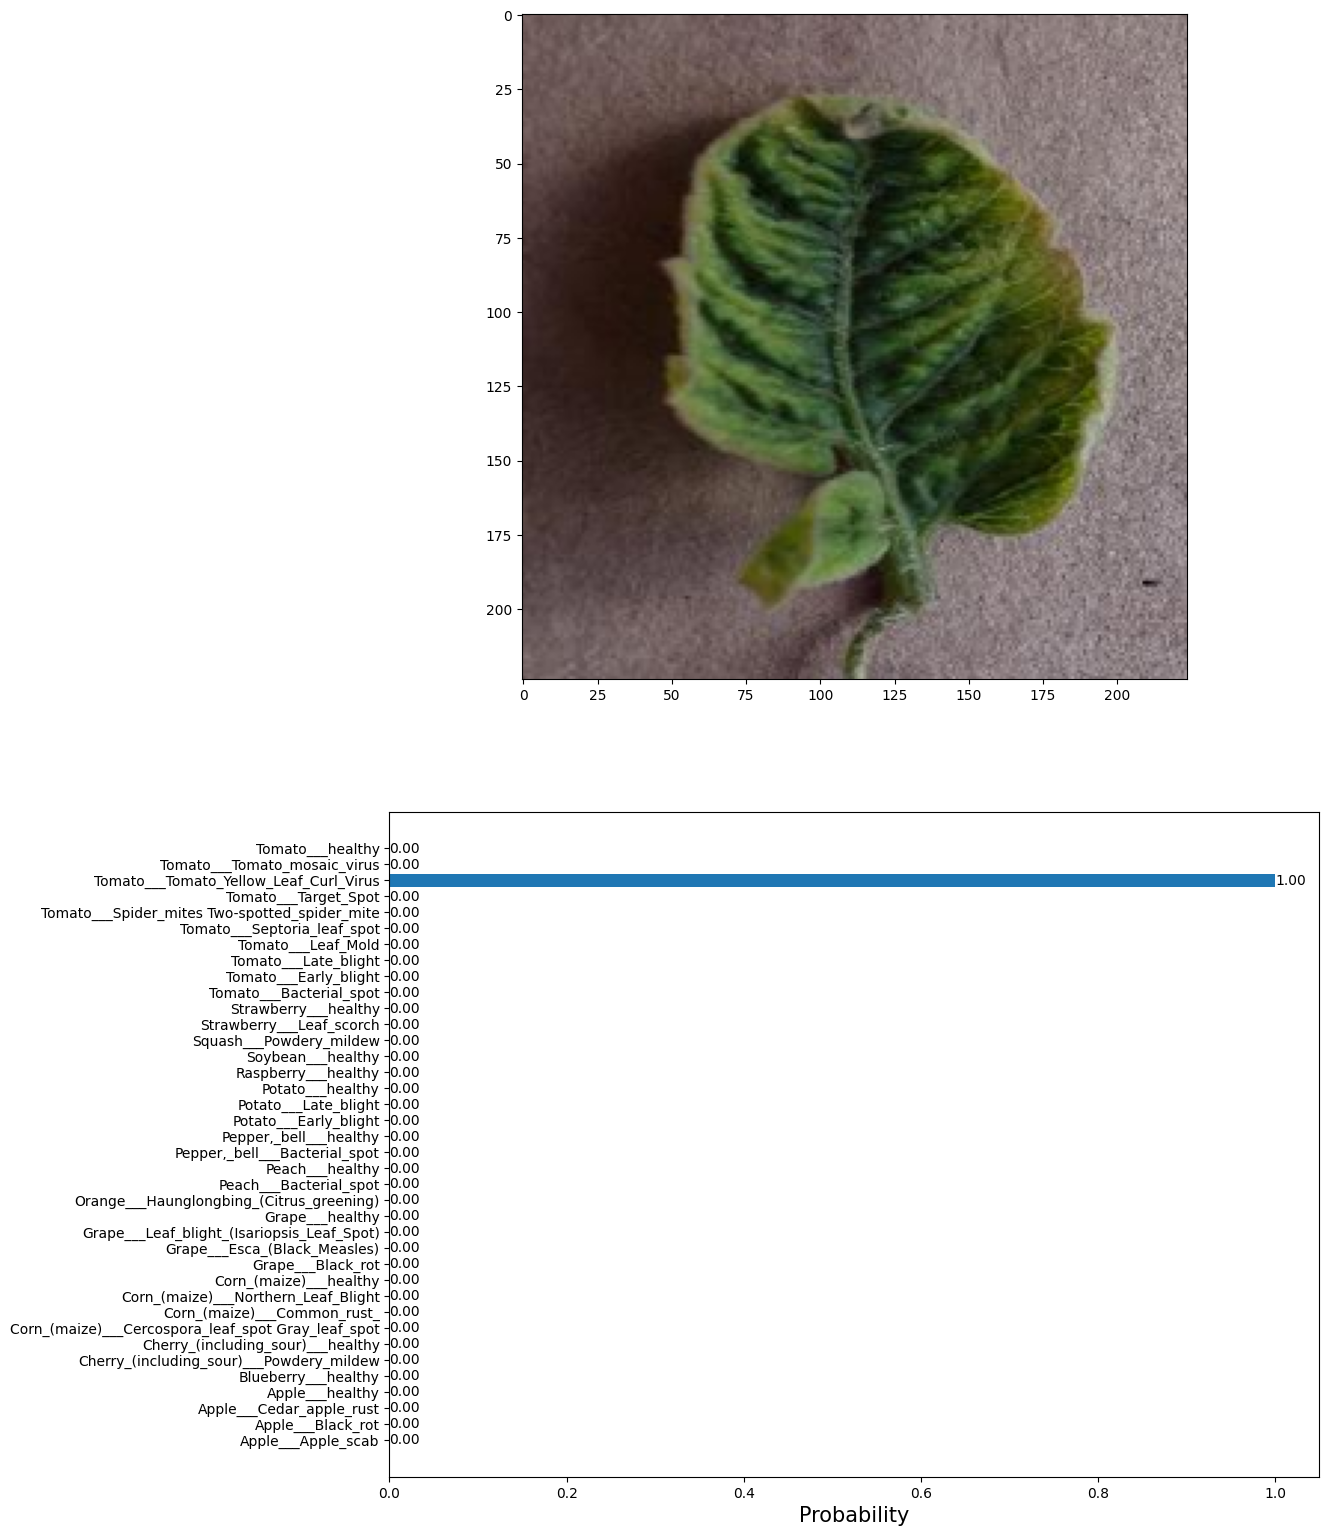

In [56]:
predict('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus2.JPG')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


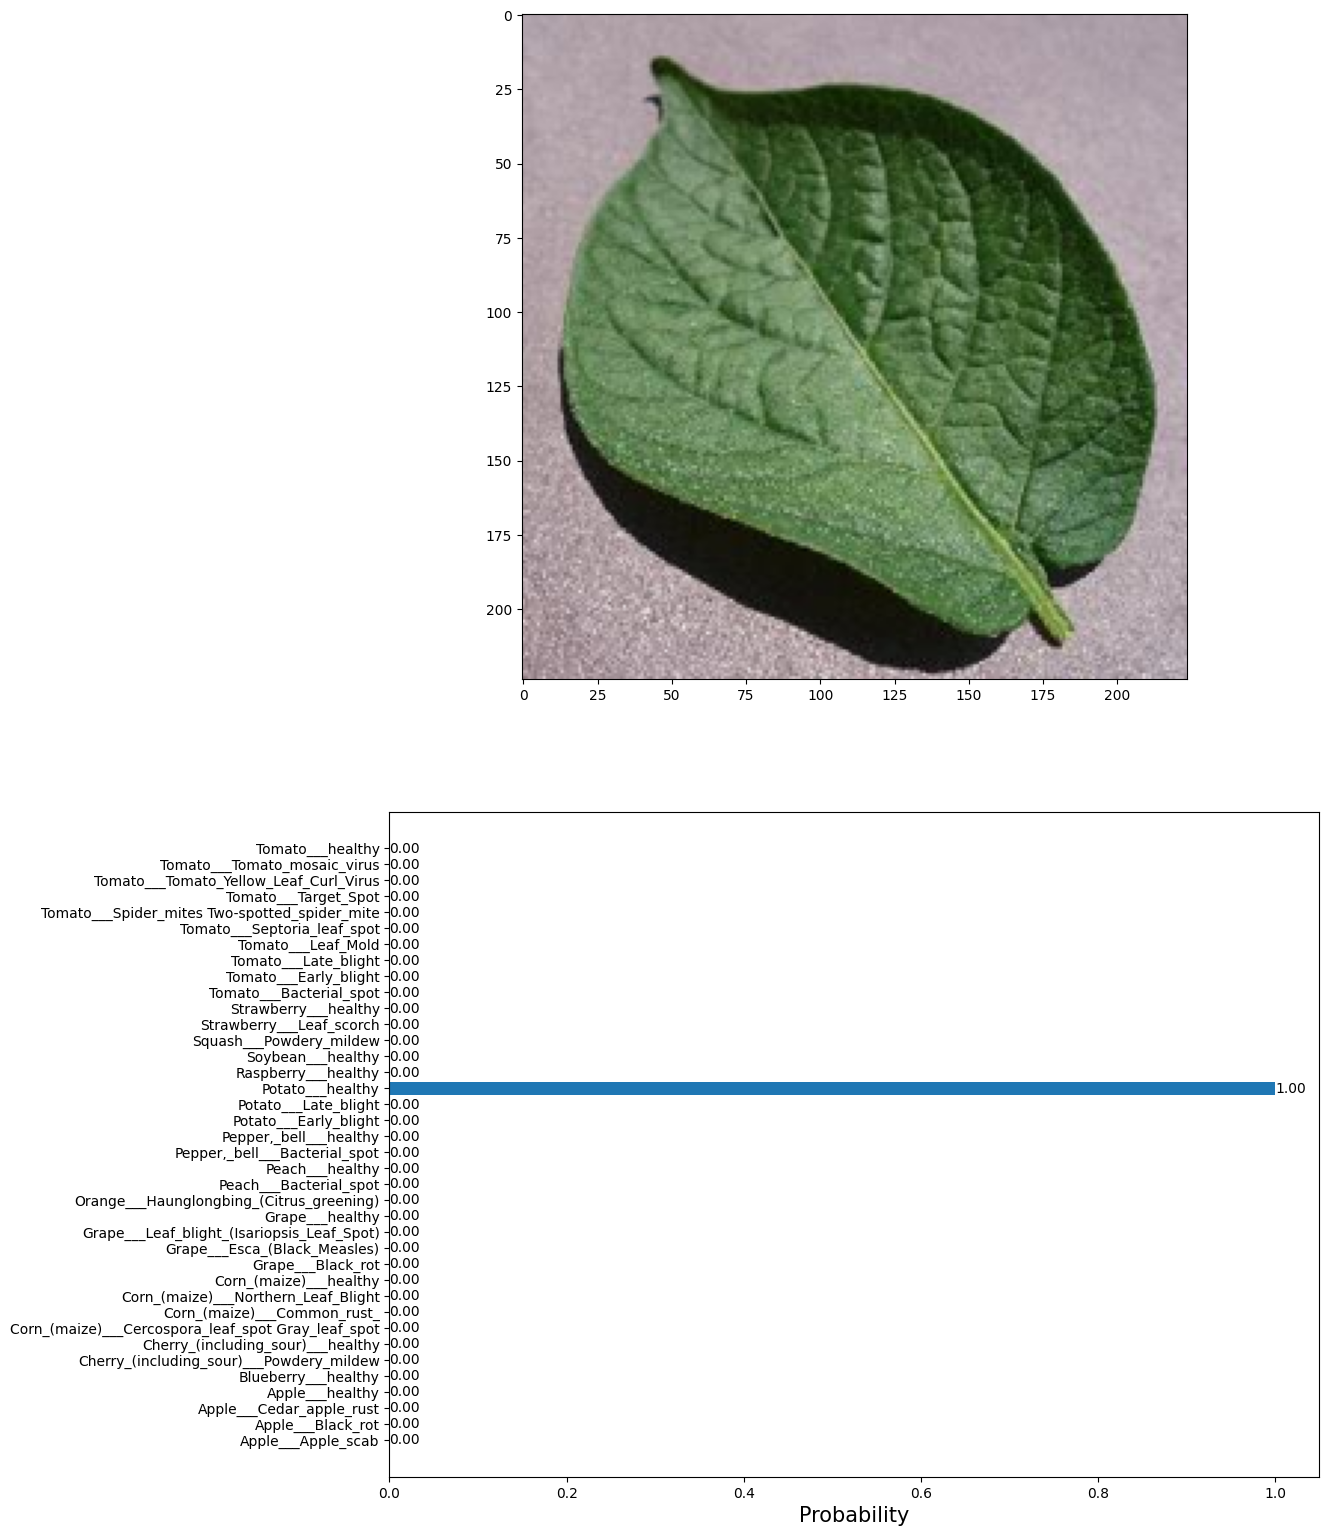

In [71]:
predict('/kaggle/input/new-plant-diseases-dataset/test/test/PotatoHealthy1.JPG')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


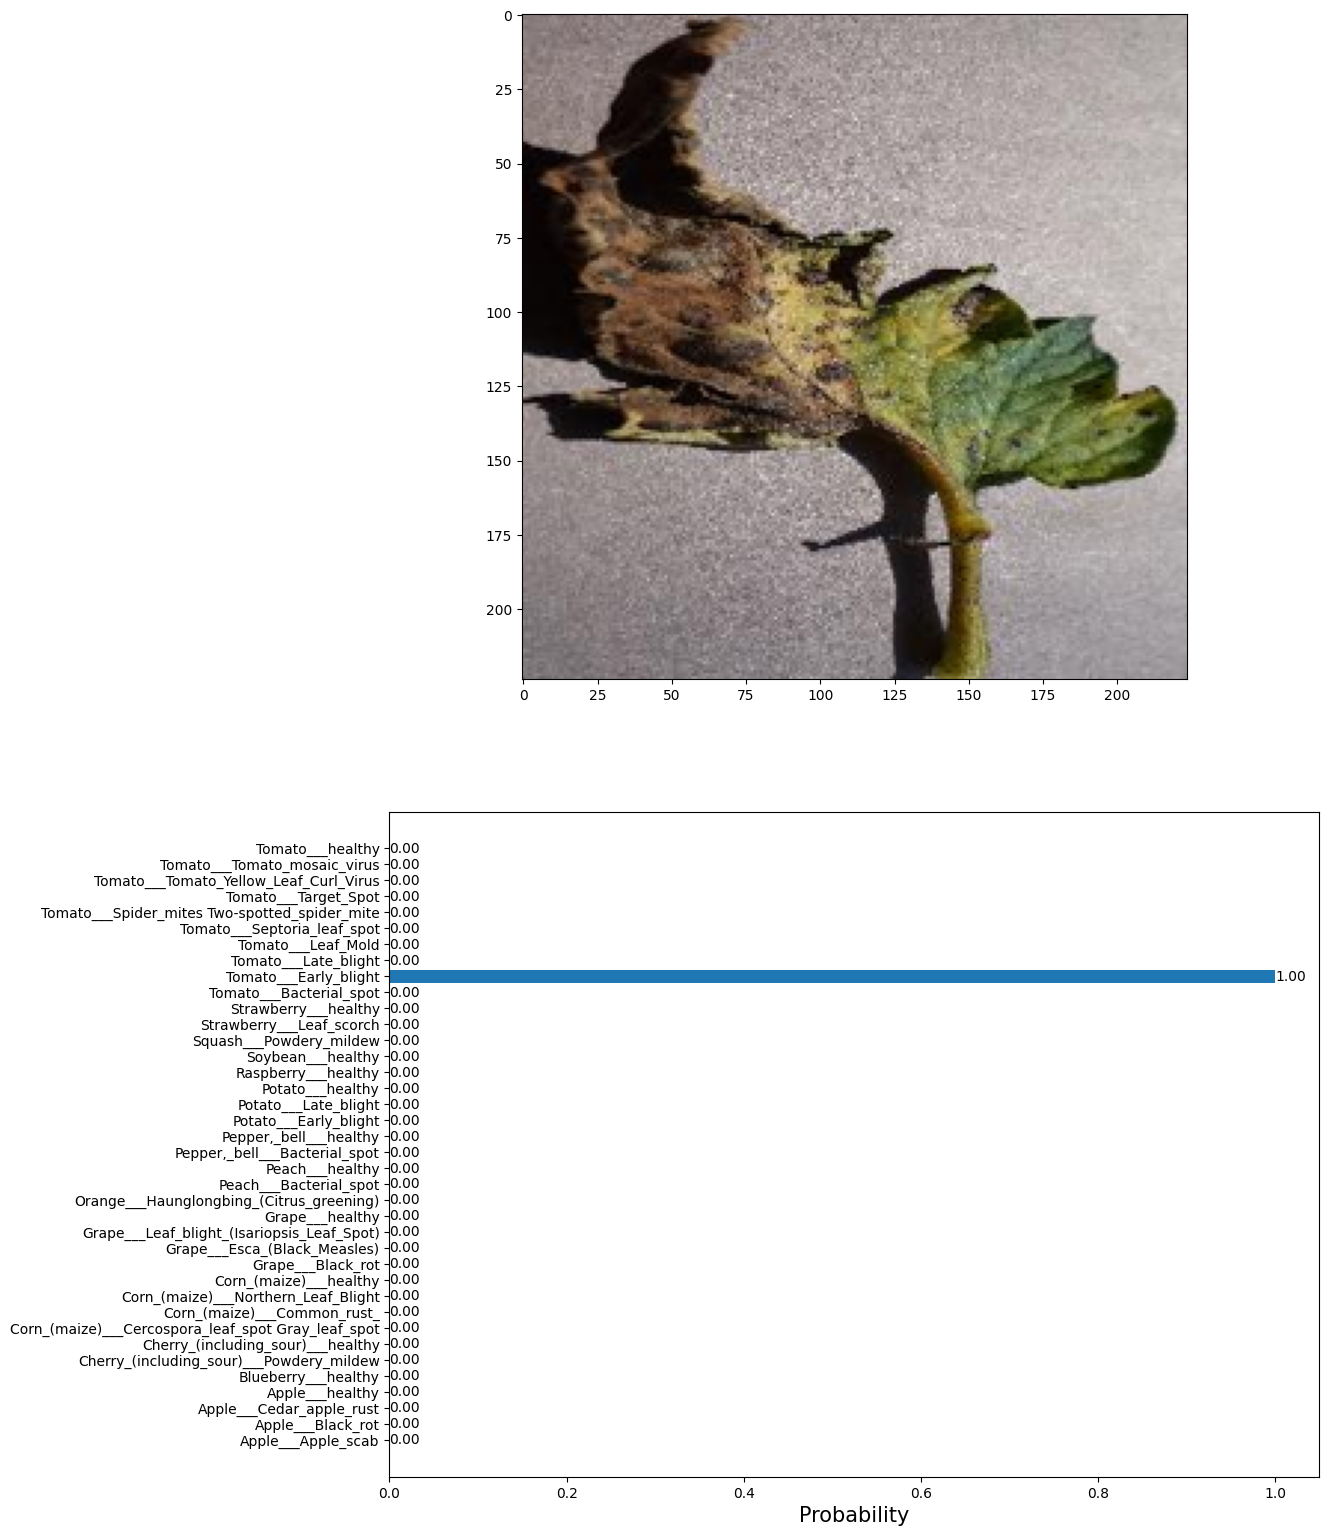

In [78]:
predict('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight1.JPG')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


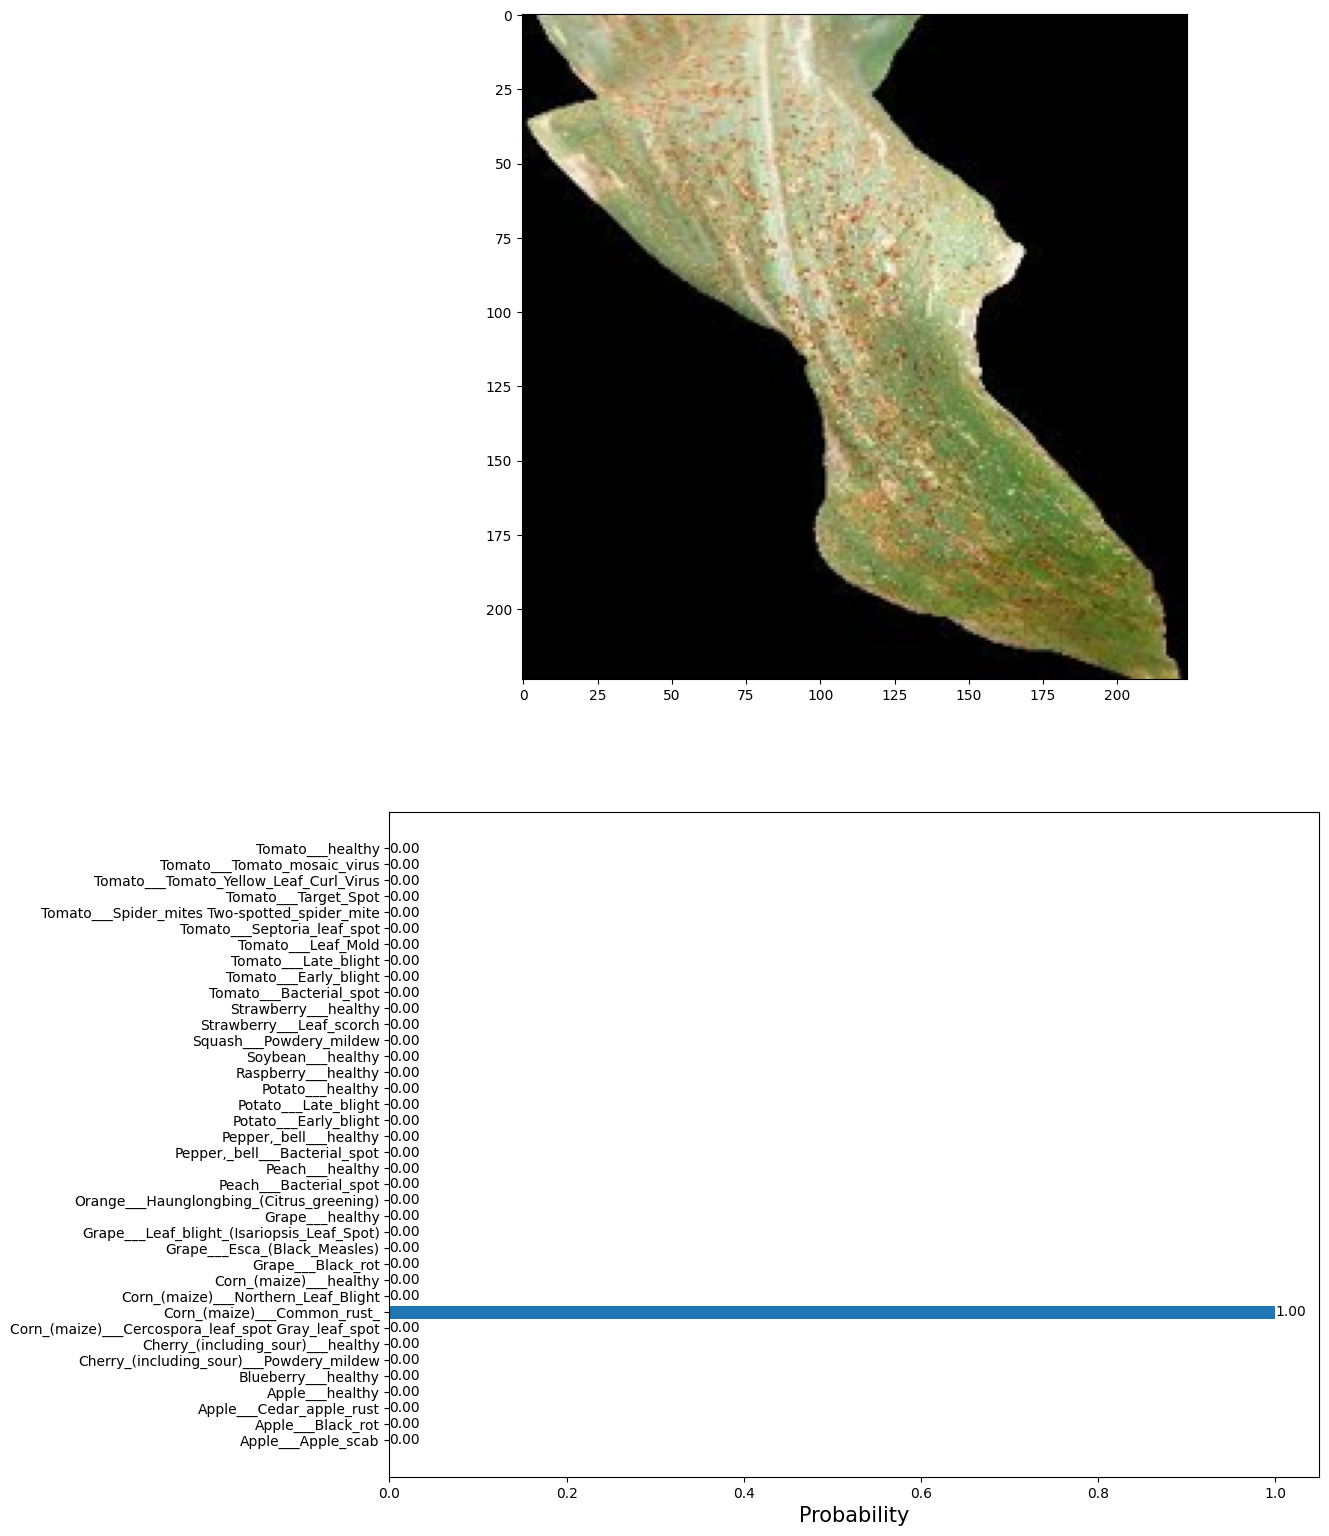

In [79]:
predict('/kaggle/input/new-plant-diseases-dataset/test/test/CornCommonRust3.JPG')



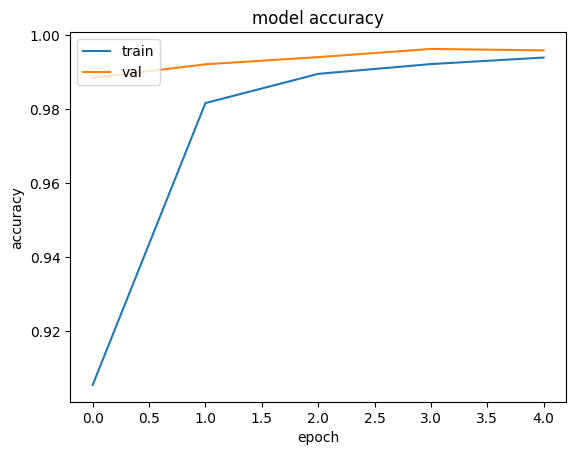

In [60]:
plt.plot(history_Final.history['accuracy'])
plt.plot(history_Final.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')